# **Project: Titanic Survival Prediction**


### Import the required libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Titanic Passenger data set
We'll be working with the Titanic passenger dataset to build a classification model to predict whether a passenger survied the sinking of the Titanic.  
Here is the data dictionary:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |


## Load the Titanic dataset using Seaborn


In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Select relevant features and the target


In [3]:
titanic.count()

survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64

#### Features to drop
`deck` has a lot of missing values so we'll drop it. `age` has quite a few missing values as well. Although it could be, `embarked` and `embark_town` don't seem relevant so we'll drop them as well. It's unclear what `alive` refers to so we'll ignore it.
#### Target
`survived` is our target class variable.


In [4]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]

### 1. How balanced are the classes?


In [5]:
# Enter your code here:
y.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

### 2. Split the data into training and testing sets
Don't forget to consider imbalance in the target


In [7]:
# Enter your code here:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Define preprocessing transformers for numerical and categorical features
#### Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features


In [8]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

#### Define separate preprocessing pipelines for both feature types


In [9]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#### Combine the transformers into a single column transformer
We'll use the sklearn "column transformer" estimator to separately transform the features, which will then concatenate the output as a single feature space, ready for input to a machine learning estimator.


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Create a model pipeline
Now let's complete the model pipeline by combining the preprocessing with a Random Forest classifier


In [11]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### Define a parameter grid 
We'll use the grid in a cross validation search to optimize the model


In [12]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

### Perform grid search cross-validation and fit the best model to the training data


In [13]:
# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

### 3. Train the pipeline model 


In [14]:
# Enter your code here
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


### 4. Get the model predictions from the grid search estimator on the unseen data
Also print a classification report


In [15]:
# Enter your code here:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



### 5. Plot the confusion matrix 


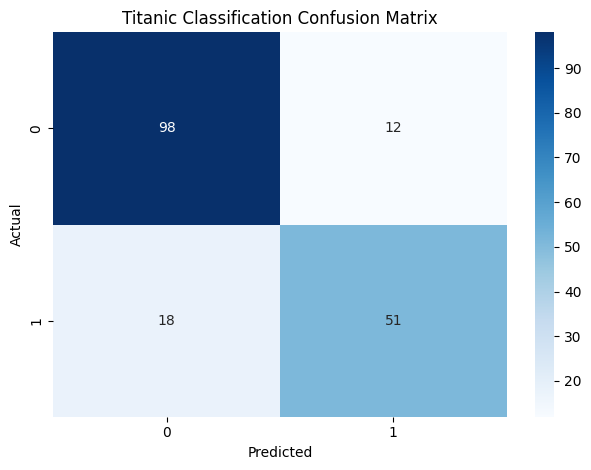

In [16]:
# Enter your code here:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

## Feature importances
Let's figure out how to get the feature importances of our overall model.  You'll need to know how to do this for your final project.  
First, to obtain the categorical feature importances, we have to work our way backward through the modelling pipeline to associate the feature importances with their one-hot encoded input features that were transformed from the original categorical features.

We don't need to trace back through the pipeline for the numerical features, because we didn't transfrom them into new ones in any way.  
Remember, we went from categorical features to one-hot encoded features, using the 'cat' column transformer.

Here's how you trace back through the trained model to access the one-hot encoded feature names:


In [17]:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman'], dtype=object)

Notice how the one-hot encoded features are named - for example, `sex` was split into two boolean features indicating whether the sex is male or female.

Great! Now let's get all of the feature importances and associate them with their transformed feature names.


In [18]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(model.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

### Display the feature importances in a bar plot
Define a feature importance DataFrame, then plot it 


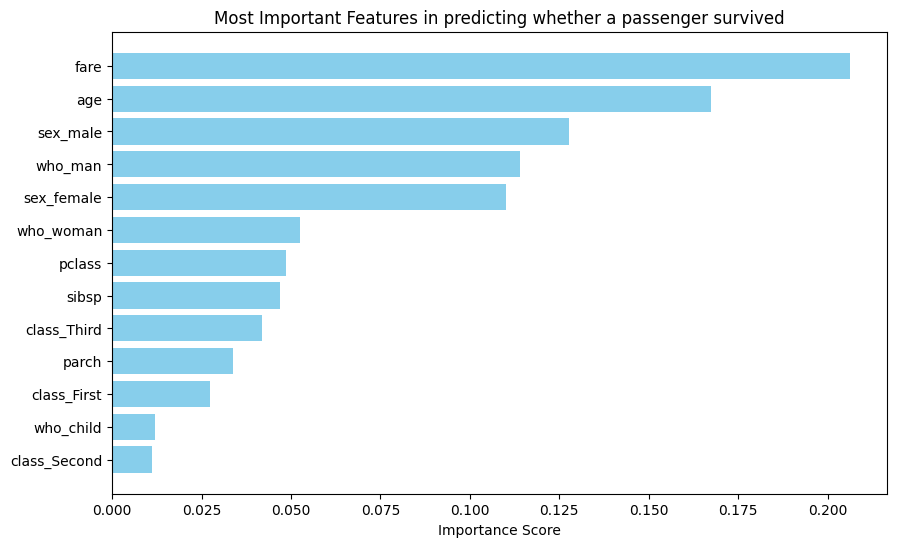


Test set accuracy: 83.24%


In [19]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score 
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

## Try another model
In practice you would want to try out different models and even revisit the data analysis to improve
your model performance. Maybe you can engineer new features or impute missing values to be able to use more data.

With Scikit-learn's powerful pipeline class, this is easy to do in a few steps.
Let's update the pipeline and the parameter grid so we can train a Logistic Regression model and compare the performance of the two models.


In [20]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

### Exercise 7. Display the clasification report for the new model and compare the results to your previous model.


In [21]:
# Enter your code here:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



### 8. Display the confusion matrix for the new model and compare the results to your previous model.


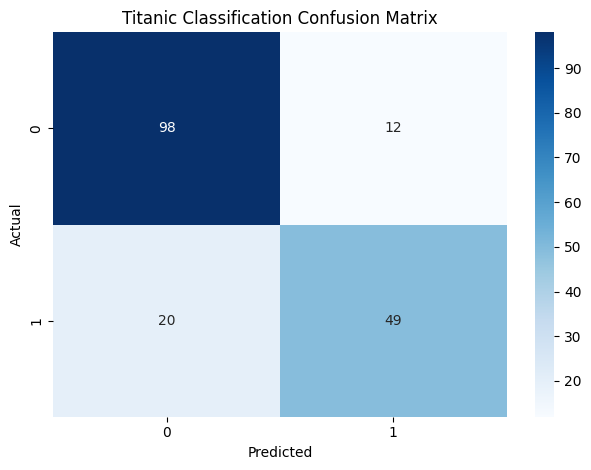

In [22]:
# Enter your code here:
# Generate the confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

# What changed in the numbers of true positives and true negatives?

### Extract the logistic regression feature coefficients and plot their magnitude in a bar chart.


In [23]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

### 9. Plot the feature coefficient magnitudes in a bar chart
What's different about this chart than the feature importance chart for the Random Forest classifier?


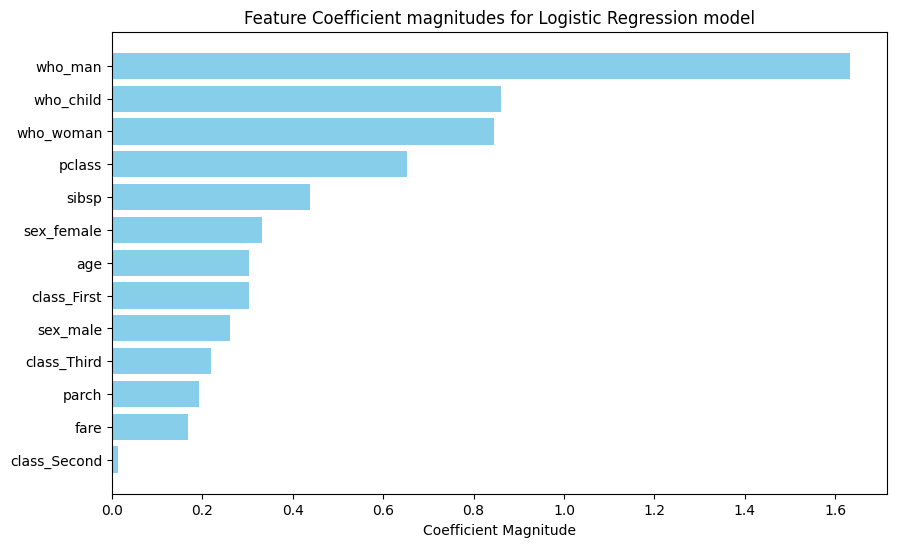


Test set accuracy: 82.12%


In [24]:
# Enter your code here:

# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")